#Bank Customer Churn
This project aims to predict the customers who might leave the bank based on the historical data provided.

#The Work Plan
Two pipelines are investigated: 1) Short Pipeline and 2) Long Pipeline with different preprocessing steps.


1.   Short Pipeline (described in the previous file)

  * Reading the dataset.
  * Splitting the data into training data (historical data) and testing data (future data).
  * Encoding the categorical features including the ordinal and not ordinal ones.
  * Modelling: 
      * Automatic tunning using Bayesian optimisation.
      * Cross-validation to check the generalisation error.
      * Training then evaluating the XGB classifier using different metrics. 

  * Results Discussion

2.   **Long Pipeline (described in this file)**

  * Reading the dataset.
  * Splitting the data into training data (historical data) and testing data (future data).
  * Encoding the categorical features including the ordinal and not ordinal ones.
  * Imputations.
  * One-Hot Encoding.
  * Analysing the dataset (Descriptive statistics, Checking the correlation).
  * Standardisation.
  * Modelling: 
      * Automatic tunning using Bayesian optimisation.
      * Cross-validation to check the generalisation error.
      * Training then evaluating different classifiers using different metrics. 
  * Results Discussion




In [1]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=58f181fae988d02132692d417878945e6d2cb085949c232f94c050f2544c0b58
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score,log_loss, confusion_matrix,classification_report, jaccard_score, \
                              f1_score, cohen_kappa_score
from sklearn.model_selection import cross_validate
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


#Long Pipeline

#Reading the dataset

In [53]:
# Making a list of missing value types
missing_values = ["Unknown","n/a", "na", "--"]

df = pd.read_csv('BankChurners.csv', na_values = missing_values)
df = df.iloc[:,1:-1]
print(df.shape)
df.head(2)

(10127, 20)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


#Splitting the Dataset 

In [4]:
# divide the dataset into 70% train and 30% test sets 
df_train, df_test = train_test_split(df,test_size= 0.3, random_state=7)
print(df_train.shape)
print(df_test.shape)

(7088, 20)
(3039, 20)


In [5]:
df_train = df_train.copy()
df_test = df_test.copy()

In [6]:
df_train.dtypes

Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [7]:
# Lists of catgorica and continuous features
catgorical_features = ['Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Attrition_Flag']

continuous_features = ['Customer_Age','Dependent_count','Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

#Encoding the columns values

In [8]:
# Ordinal Number Encoding
AttritionDict =   {'Existing Customer':0,
                    'Attrited Customer':1}

EduDict =   {'Uneducated':1,
             'High School':2,
             'College': 3,
             'Graduate': 4,
             'Doctorate': 5,
             'Post-Graduate': 6 }

MaritalDict =   {'Single':1,
                    'Married':2,
                    'Divorced':3}

IncomeDict =   {'Less than $40K':1,
             '$40K - $60K':2,
             '$60K - $80K': 3,
             '$80K - $120K': 4,
             '$120K +': 5}

CardDict =   {'Blue':1,
             'Silver':2,
             'Gold': 3,
             'Platinum': 4 }


df_train['Attrition_Flag'] = df_train['Attrition_Flag'].map(AttritionDict)

df_train['Education_Level'] = df_train['Education_Level'].map(EduDict)

df_train['Marital_Status'] = df_train['Marital_Status'].map(MaritalDict)

df_train['Income_Category'] = df_train['Income_Category'].map(IncomeDict)

df_train['Card_Category'] = df_train['Card_Category'].map(CardDict)


# Encoding of unordinal feature 'Gender'
enc = LabelEncoder()
enc.fit(df_train['Gender'])
df_train['Gender'] = enc.transform(df_train['Gender'])

In [9]:
# Encoding the test set (future data)
df_test['Attrition_Flag'] = df_test['Attrition_Flag'].map(AttritionDict)

df_test['Education_Level'] = df_test['Education_Level'].map(EduDict)

df_test['Marital_Status'] = df_test['Marital_Status'].map(MaritalDict)

df_test['Income_Category'] = df_test['Income_Category'].map(IncomeDict)

df_test['Card_Category'] = df_test['Card_Category'].map(CardDict)

enc = LabelEncoder()
enc.fit(df_test['Gender'])
df_test['Gender'] = enc.transform(df_test['Gender'])

#Imputations
There are many techniques to handle the null values, I chose the commonly used one (replacing with the median). This choice makes sense as the features are skewed.

In [10]:
edu_cond = df_train['Education_Level'].notna() 
status_cond = df_train['Marital_Status'].notna() 
income_cond = df_train['Income_Category'].notna() 


# Replace using median 
edu_median = df_train[edu_cond]['Education_Level'].median()
df_train['Education_Level'].fillna(edu_median, inplace=True)

# Replace using median 
status_median = df_train[status_cond]['Marital_Status'].median()
df_train['Marital_Status'].fillna(status_median, inplace=True)

# Replace using median 
income_median = df_train[income_cond]['Income_Category'].median()
df_train['Income_Category'].fillna(income_median, inplace=True)

In [11]:
# Replace using median 
df_test['Education_Level'].fillna(edu_median, inplace=True)

# Replace using median 
df_test['Marital_Status'].fillna(status_median, inplace=True)

# Replace using median 
df_test['Income_Category'].fillna(income_median, inplace=True)

In [12]:
# check if any null values in the dataset
df_train.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

#One-Hot Encoding
After encoding the ordinal features, I one-hot encoded them to make sure I preserve the ordinal characteristics.

In [13]:
from sklearn.preprocessing import LabelBinarizer

# Excluding Attrition_Flag and Gender as they are already have only two values 

df_train_one_hot = pd.DataFrame()
for feature in catgorical_features[1:5]:
  lb = LabelBinarizer()
  lb_results = lb.fit_transform(df_train[feature])
  column_name = [feature + '_' + str(l) for l in lb.classes_]
  lb_results_df = pd.DataFrame(lb_results, columns=column_name, index=df_train.index)
  df_train_one_hot = pd.concat([df_train_one_hot, lb_results_df], axis=1)

df_test_one_hot = pd.DataFrame()
for feature in catgorical_features[1:5]:
  lb = LabelBinarizer()
  lb_results = lb.fit_transform(df_test[feature])
  column_name = [feature + '_' + str(l) for l in lb.classes_]
  lb_results_df = pd.DataFrame(lb_results, columns=column_name, index=df_test.index)
  df_test_one_hot = pd.concat([df_test_one_hot, lb_results_df], axis=1)

In [14]:
# concatenate with Attrition_Flag and Gender
df_train_one_hot = pd.concat([df_train['Attrition_Flag'], df_train['Gender'], df_train_one_hot], axis=1)
df_train_one_hot.head()

,Attrition_Flag,Gender,Education_Level_1.0,Education_Level_2.0,Education_Level_3.0,Education_Level_4.0,Education_Level_5.0,Education_Level_6.0,Marital_Status_1.0,Marital_Status_2.0,Marital_Status_3.0,Income_Category_1.0,Income_Category_2.0,Income_Category_3.0,Income_Category_4.0,Income_Category_5.0,Card_Category_1,Card_Category_2,Card_Category_3,Card_Category_4
5514,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0
4510,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
6655,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
7381,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3460,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [15]:
# concatenate with Attrition_Flag and Gender
df_test_one_hot = pd.concat([df_test['Attrition_Flag'], df_test['Gender'], df_test_one_hot], axis=1)
df_test_one_hot.head()

,Attrition_Flag,Gender,Education_Level_1.0,Education_Level_2.0,Education_Level_3.0,Education_Level_4.0,Education_Level_5.0,Education_Level_6.0,Marital_Status_1.0,Marital_Status_2.0,Marital_Status_3.0,Income_Category_1.0,Income_Category_2.0,Income_Category_3.0,Income_Category_4.0,Income_Category_5.0,Card_Category_1,Card_Category_2,Card_Category_3,Card_Category_4
2914,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1592,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
3577,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
6390,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4106,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0


#Analysing the Dataset
Descriptive statistics

In [16]:
df_train[continuous_features].describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000
mean,46.317156,2.349041,35.931151,3.810384,2.332957,2.451891,8682.295387,1162.326044,7519.969343,0.761276,4418.978273,64.845655,0.712106,0.273316
std,7.984914,1.298341,7.924207,1.553848,1.011868,1.107945,9082.230704,812.293571,9078.833947,0.217943,3413.937562,23.555192,0.239299,0.275372
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2571.000000,428.000000,1353.750000,0.632000,2166.500000,45.000000,0.583000,0.025000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4619.000000,1272.500000,3563.500000,0.738000,3891.500000,67.000000,0.704000,0.174500
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11188.250000,1779.000000,9959.000000,0.860000,4747.000000,81.000000,0.818000,0.496000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,138.000000,3.714000,0.999000


In [17]:
df_train['Attrition_Flag'].value_counts()

0    5927
1    1161
Name: Attrition_Flag, dtype: int64

In [18]:
df_train['Gender'].value_counts()

0    3714
1    3374
Name: Gender, dtype: int64

In [19]:
df_train['Education_Level'].value_counts()

4.0    2200
3.0    1766
2.0    1419
1.0    1035
6.0     361
5.0     307
Name: Education_Level, dtype: int64

In [20]:
df_train['Marital_Status'].value_counts()

2.0    3784
1.0    2764
3.0     540
Name: Marital_Status, dtype: int64

In [21]:
df_train['Income_Category'].value_counts()

1.0    2464
2.0    2035
4.0    1083
3.0     993
5.0     513
Name: Income_Category, dtype: int64

In [22]:
df_train['Card_Category'].value_counts()

1    6594
2     393
3      87
4      14
Name: Card_Category, dtype: int64

#Check the corrlation
Coefficient matrix

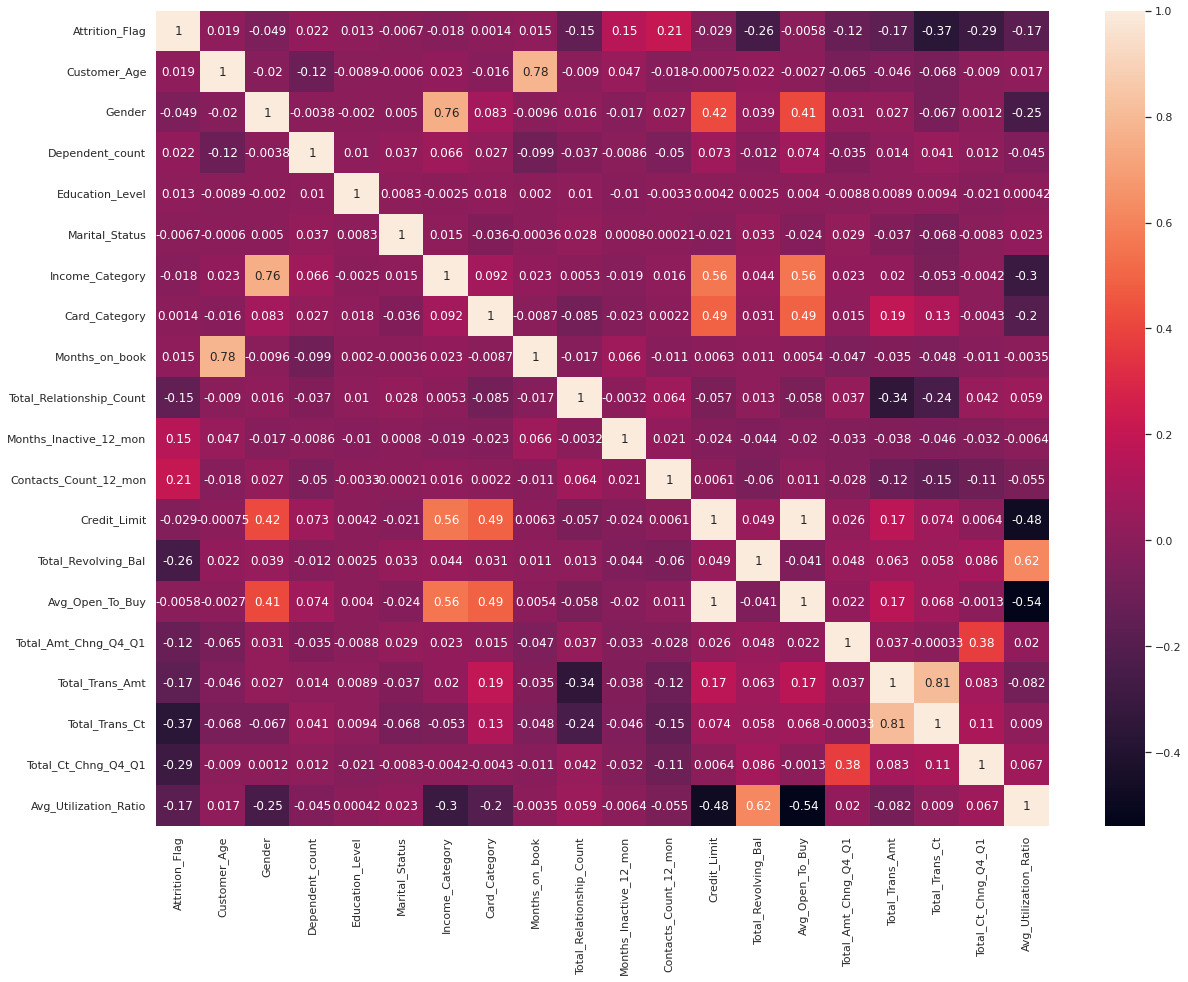

In [23]:
sns.set(font_scale=1) 
df_corr = df_train.corr()
plt.figure(figsize=(20,15))
sns.heatmap(df_corr,annot=True)

In [24]:
# take the highest 10 positively corredlated feature with the target
# sub_features = df_corr['Attrition_Flag'].sort_values(ascending=False).iloc[1:].head(10).index.values
# sub_features = np.append(sub_features,['Attrition_Flag'], axis=0 )

# take the highest 10 positively and negatively corredlated feature with the target
filt = (df_corr.loc['Attrition_Flag']>0.10) | (df_corr.loc['Attrition_Flag']<-0.10)
sub_features = df_corr[filt].index.values

print(len(sub_features))

10


In [25]:
sub_features

array(['Attrition_Flag', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
       'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype=object)

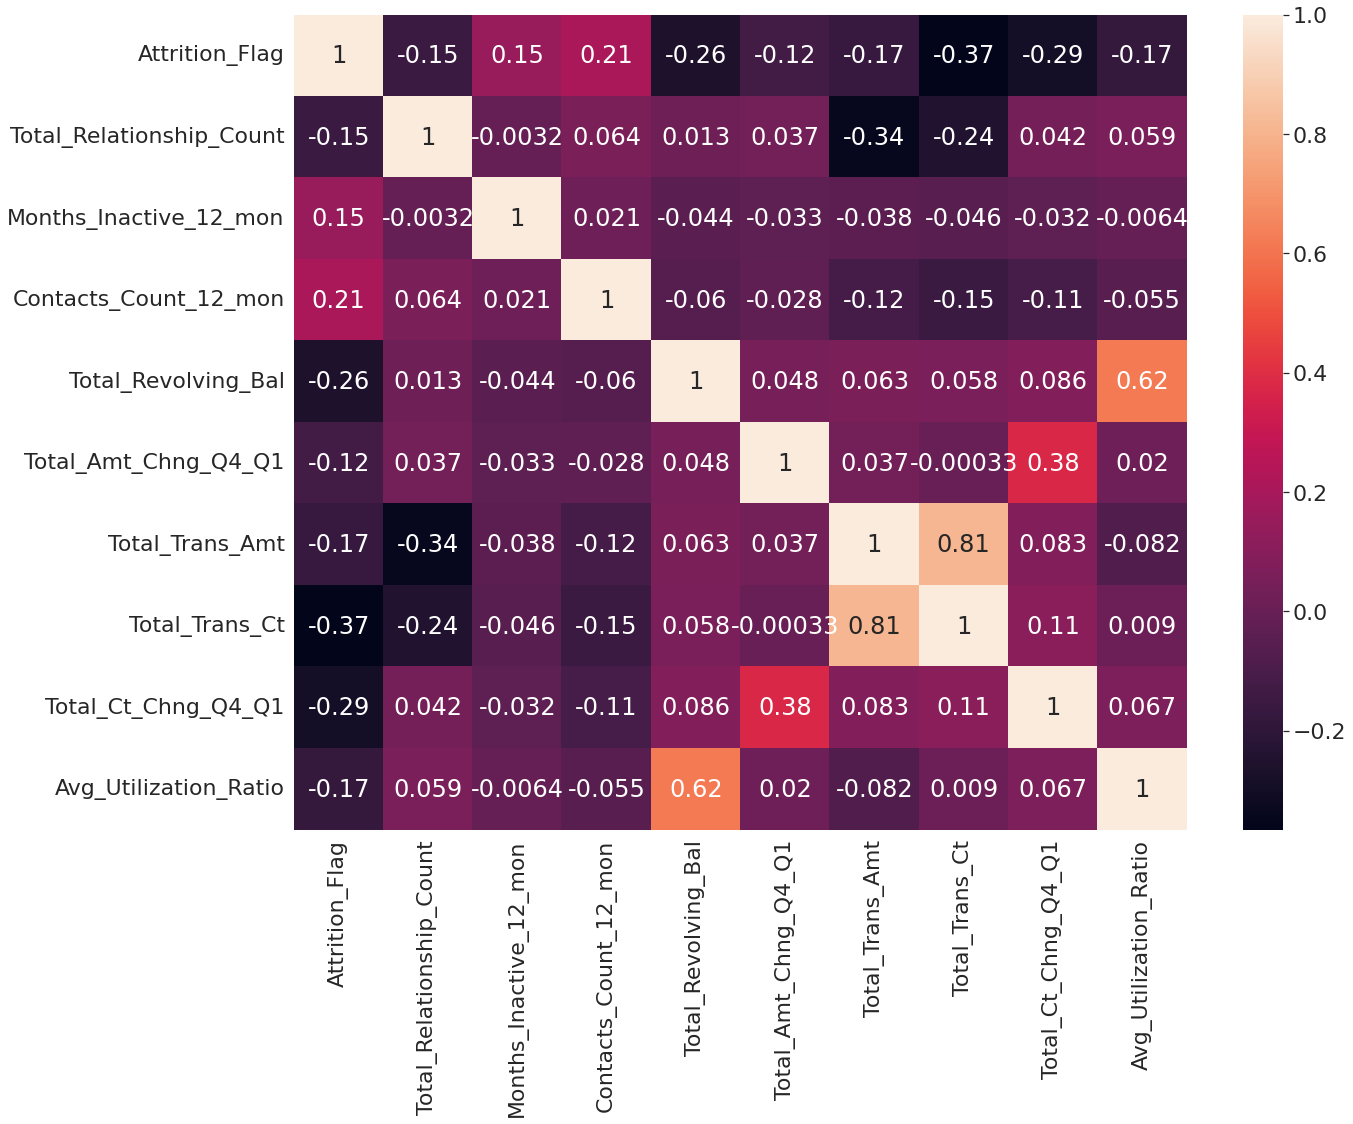

In [26]:
sns.set(font_scale=2) 
sub_df_corr = df_train[sub_features].corr()
plt.figure(figsize=(20,15))
sns.heatmap(sub_df_corr,annot=True)

In [27]:
# uncomment to use only corrleated sub_features
# However I found using all the features has obatined a little bit better results
# df_train = df_train[sub_features]

#Standrediztion
As we can see from the histogram below that some of the features are skewed positively like Credit_Limit and Avg_Open_To_Buy. We can handle the skewness using many ways including using BoxCox transformation (boxcox1p 1 + x)  or Square Root or Log transformation. However, I tried BoxCox one and it gave worse results.





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


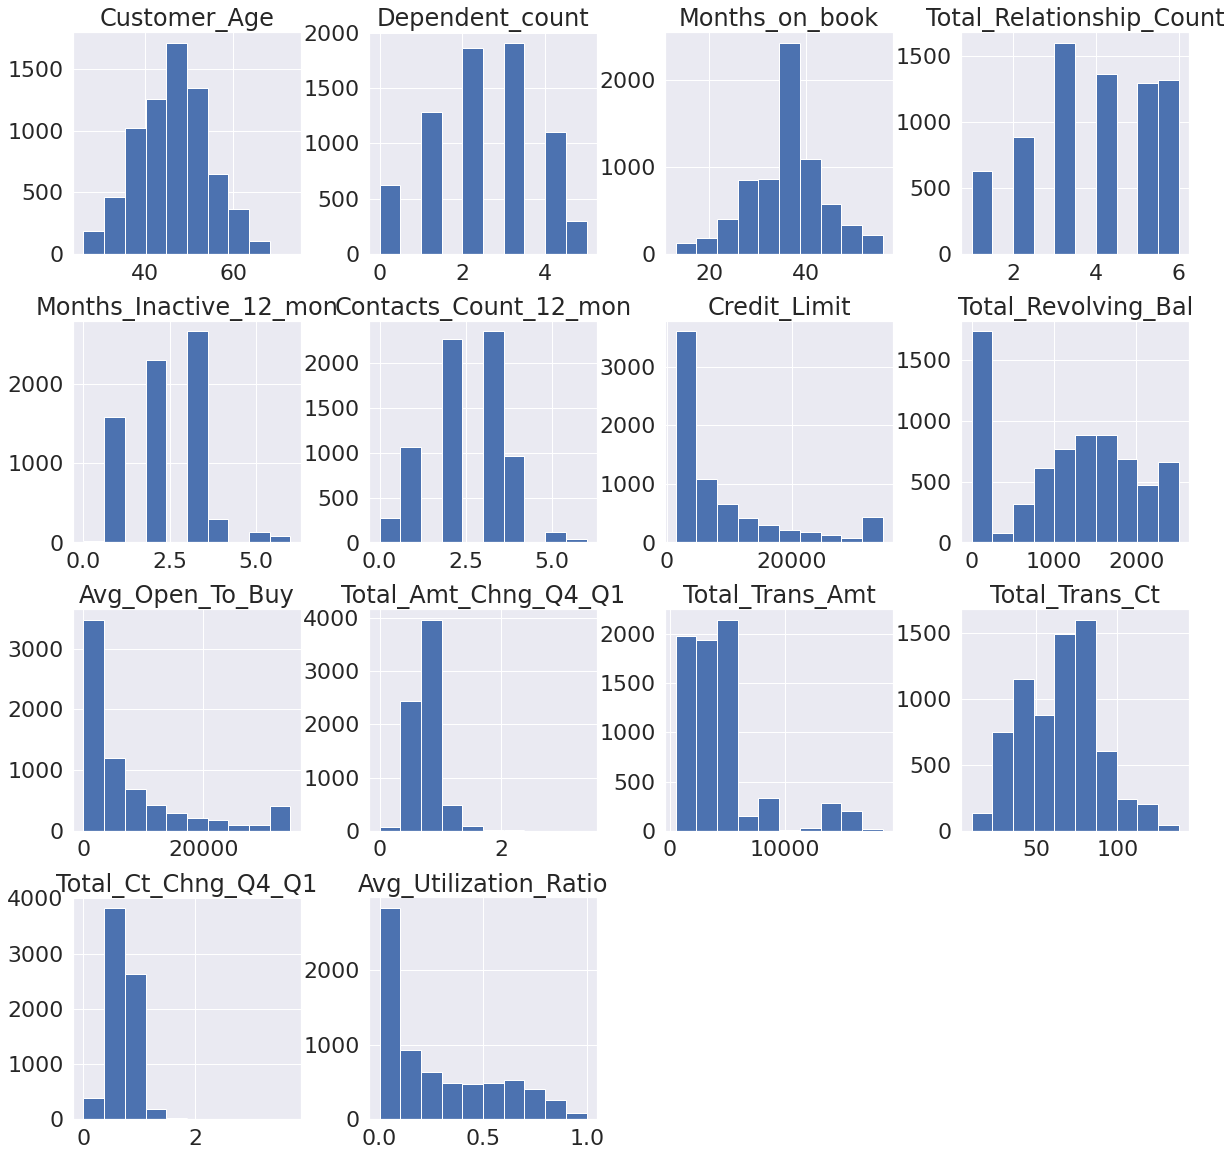

In [28]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
df_train[continuous_features].hist(ax = ax)
plt.show()

In [29]:
# calculate the skewness 
df_train.skew()

Attrition_Flag              1.817240
Customer_Age               -0.038744
Gender                      0.096068
Dependent_count            -0.020045
Education_Level             0.161833
Marital_Status              0.283658
Income_Category             0.649092
Card_Category               4.535863
Months_on_book             -0.102897
Total_Relationship_Count   -0.154549
Months_Inactive_12_mon      0.627543
Contacts_Count_12_mon       0.031874
Credit_Limit                1.655493
Total_Revolving_Bal        -0.146216
Avg_Open_To_Buy             1.650563
Total_Amt_Chng_Q4_Q1        1.707239
Total_Trans_Amt             2.026213
Total_Trans_Ct              0.163524
Total_Ct_Chng_Q4_Q1         2.337068
Avg_Utilization_Ratio       0.740671
dtype: float64

In [30]:
# Normalise the input features
sclar = StandardScaler()
df_train_cont = sclar.fit(df_train[continuous_features]).fit_transform(df_train[continuous_features])
df_test_cont = sclar.fit(df_test[continuous_features]).fit_transform(df_test[continuous_features])

In [31]:
df_train_cont.shape

(7088, 14)

In [32]:
df_train_Stand = pd.DataFrame(df_train_cont, columns= continuous_features, index= df_train[continuous_features].index)

# uncomment to not use one-hot econded features (and comment the next line)
# df_train_Stand[catgorical_features] =  df_train[catgorical_features]

# using one-hot econded features
df_train_Stand[df_train_one_hot.columns] = df_train_one_hot

df_train_Stand.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Gender,Education_Level_1.0,Education_Level_2.0,Education_Level_3.0,Education_Level_4.0,Education_Level_5.0,Education_Level_6.0,Marital_Status_1.0,Marital_Status_2.0,Marital_Status_3.0,Income_Category_1.0,Income_Category_2.0,Income_Category_3.0,Income_Category_4.0,Income_Category_5.0,Card_Category_1,Card_Category_2,Card_Category_3,Card_Category_4
5514,0.336013,0.501413,-0.874742,0.765648,-0.329075,-0.407892,1.057271,-0.022562,1.059686,0.026264,0.125091,1.152878,0.099859,-0.763808,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0
4510,0.336013,0.501413,0.008689,-0.521570,0.659266,-0.407892,0.517498,-0.004095,0.518058,-1.639425,-0.758995,-0.842577,-0.886424,-0.676647,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
6655,1.337973,1.271682,0.008689,-0.521570,3.624287,0.494743,-0.471976,-0.404225,-0.435986,-0.464724,0.119232,0.983052,0.839571,-0.302581,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
7381,0.210768,1.271682,0.765916,0.765648,1.647606,0.494743,-0.528905,0.063619,-0.534795,0.746687,0.216487,0.600944,-0.129995,0.144120,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3460,0.586503,-0.268855,0.008689,-0.521570,-1.317416,0.494743,-0.566563,-1.431020,-0.438740,-0.524377,-0.093148,0.643400,-0.042233,-0.992606,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0


In [33]:
df_test_Stand = pd.DataFrame(df_test_cont, columns= continuous_features, index= df_test[continuous_features].index)

# uncomment to not use one-hot econded features (and comment the next line)
# df_test_Stand[catgorical_features] =  df_test[catgorical_features]

# using one-hot econded features
df_test_Stand[df_test_one_hot.columns] = df_test_one_hot

df_test_Stand.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Gender,Education_Level_1.0,Education_Level_2.0,Education_Level_3.0,Education_Level_4.0,Education_Level_5.0,Education_Level_6.0,Marital_Status_1.0,Marital_Status_2.0,Marital_Status_3.0,Income_Category_1.0,Income_Category_2.0,Income_Category_3.0,Income_Category_4.0,Income_Category_5.0,Card_Category_1,Card_Category_2,Card_Category_3,Card_Category_4
2914,0.327971,-1.030286,0.009593,1.402774,0.634953,1.394250,-0.644796,0.407981,-0.680539,-0.390940,-0.035252,0.176594,-0.763052,1.043514,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1592,-2.514807,-1.799394,-2.819562,0.117180,-1.350256,-0.420365,-0.452550,0.092602,-0.460186,-0.426961,-0.624705,-0.811432,-1.166907,0.012401,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
3577,0.698768,0.507930,0.747633,-0.525617,-0.357651,-1.327673,1.685550,0.018323,1.681270,-0.386437,-0.174350,0.176594,-0.125386,-0.830578,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
6390,1.563961,-1.030286,1.977701,1.402774,0.634953,0.486943,-0.681817,1.132501,-0.782764,-0.156805,0.148822,0.520256,0.159438,2.273612,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4106,0.451570,-1.030286,0.132600,-0.525617,-1.350256,-2.234980,0.389925,0.180275,0.373078,-1.327478,-0.080228,0.090679,-0.159395,-0.613502,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [34]:
df_test_Stand.shape

(3039, 34)

In [35]:
df_train_Stand.shape

(7088, 34)

#Modeling

In [36]:
# The features in df_train and df_test are
#  1) encoded with integers and
#  2) imputed (null values are handled)

# The features in df_train_Stand and df_test_Stand are
#  1) encoded with integers;
#  2) imputed (null values are handled)
#  3) one-hot encoded
#  4) standardised

# extract the train input features and the target feature
y_train = df_train['Attrition_Flag']
x_train = df_train.drop('Attrition_Flag', axis=1)

# extract the test input features and the target feature
y_test = df_test['Attrition_Flag']
x_test = df_test.drop('Attrition_Flag', axis=1)

# extract the standardised train input features and the target feature
y_train_Stand = df_train_Stand['Attrition_Flag']
x_train_Stand = df_train_Stand.drop('Attrition_Flag', axis=1)

# extract the standardised test input features and the target feature
y_test_Stand = df_test_Stand['Attrition_Flag']
x_test_Stand = df_test_Stand.drop('Attrition_Flag', axis=1)

# check how many each class do we have from the target feature
print(y_train.value_counts())
print(y_test.value_counts())

0    5927
1    1161
Name: Attrition_Flag, dtype: int64
0    2573
1     466
Name: Attrition_Flag, dtype: int64


In [37]:
# define a function for cross-valdation
kappa_scorer = make_scorer(cohen_kappa_score)
f1_scorer = make_scorer(f1_score)

@ignore_warnings(category=ConvergenceWarning)
def cross_valid_fun(model, features, target, cv, scorer):
  cv_results = cross_validate(model, features, target, cv=cv, scoring=scorer)
  CV_mean = cv_results['test_score'].mean()
  CV_std = cv_results['test_score'].std()
  return CV_mean, CV_std

In [38]:
# define function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
# define a function for printing the metrices
def metrics(y_test, y_hat, y_prob):
  # extract the model accuracy
  print("Accuracy : {:.2%}".format(accuracy_score(y_test, y_hat)))
  # F1
  print("F1 : {:.2%}".format(f1_score(y_test, y_hat)))
  # extract jaccard score
  print("Jaccard : {:.2f}".format(jaccard_score(y_test,y_hat)))
  # Kappa
  print("Kappa : {:.2f}".format(cohen_kappa_score(y_test, y_hat)))
  # extract the log loss metric
  print("log_loss : {:.2f}".format(log_loss(y_test, y_prob)),'\n')

  # extract the classification report
  print(classification_report(y_test,y_hat))    


  # Compute confusion matrix
  cnf_matrix = confusion_matrix(y_test, y_hat, labels=[0,1])
  # Plot non-normalized confusion matrix
  sns.set(font_scale=1)
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=['churn=0','churn=1'],normalize= False,  title='Confusion matrix')

#Tunning

In [40]:
from bayes_opt import BayesianOptimization

def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    estimator_function = XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = seed)
    
    x_train_temp, x_val_temp , y_train_temp, y_val_temp = train_test_split(x_train,y_train, test_size= 0.3, random_state=7)
    # Fit the estimator
    estimator_function.fit(x_train_temp, y_train_temp)
    
    y_hat = estimator_function.predict(x_val_temp)
    kappa_val = cohen_kappa_score(y_val_temp, y_hat)
      
    return np.array(kappa_val)

gp_params = {"alpha": 1e-10}

seed = 112 # Random seed

hyperparameter_space = {
    'max_depth': (5, 100),
    'learning_rate': (0, 1),
    'n_estimators' : (10,1000),
    'reg_alpha': (0,1)
}


xgbcBO = BayesianOptimization(f = xgbc_cv, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

xgbcBO.maximize(init_points=3,n_iter=30,acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | learni... | max_depth | n_esti... | reg_alpha |
-------------------------------------------------------------------------
|  1        |  0.879    |  0.3751   |  65.83    |  950.5    |  0.07568  |
|  2        |  0.8592   |  0.7769   |  84.11    |  64.26    |  0.8177   |
|  3        |  0.875    |  0.8854   |  73.62    |  12.53    |  0.9812   |
|  4        |  0.8836   |  0.4418   |  5.129    |  568.8    |  0.7058   |
|  5        |  0.8856   |  0.103    |  5.178    |  990.7    |  0.595    |
|  6        |  0.8172   |  0.1339   |  5.265    |  15.0     |  0.6709   |
|  7        |  0.8875   |  0.2149   |  5.167    |  994.4    |  0.9304   |
|  8        |  0.8735   |  0.9312   |  99.95    |  509.6    |  0.6218   |
|  9        |  0.8798   |  0.4295   |  98.17    |  690.1    |  0.9635   |
|  10       |  0.8784   |  0.09857  |  96.31    |  999.4    |  0.6125   |
|  11       |  0.8732   |  0.7795   |  5.001    |  367.1    |  0.6324   |
|  12       |  0.8719   |  0.8518   | 

#XGB Classifier
 The input features here are:
1.   Encoded with integers and
2.   Imputed (null values are handled)


Here the input data is the imputed features (handle the null values). While in the first file there was no imputation (the results were a little bit better than using imputation for XGB Classifier).

In [41]:
XGB = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.4434,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=750, 
                      reg_alpha = 0.9185,
                      max_depth=6, 
                      gamma=10)
CV_mean_Kappa, CV_std_Kappa = cross_valid_fun(XGB, x_train, y_train, 10, kappa_scorer)
CV_mean_F1, CV_std_F1 = cross_valid_fun(XGB, x_train, y_train, 10, f1_scorer)

print("Kappa mean:{:.2f} std:{:.2f}".format(CV_mean_Kappa, CV_std_Kappa))
print("F1 mean:{:.2%} std:{:.2%}".format(CV_mean_F1, CV_std_F1))

Kappa mean:0.88 std:0.02
F1 mean:89.98% std:2.01%


Accuracy : 96.71%
F1 : 88.84%
Jaccard : 0.80
Kappa : 0.87
log_loss : 0.09 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2573
           1       0.93      0.85      0.89       466

    accuracy                           0.97      3039
   macro avg       0.95      0.92      0.93      3039
weighted avg       0.97      0.97      0.97      3039



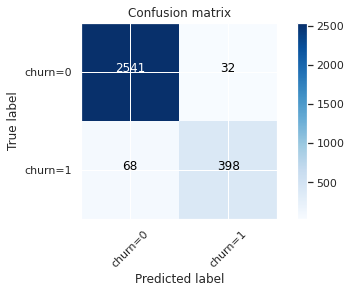

In [42]:
XGB = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.4434,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=750, 
                      reg_alpha = 0.9185,
                      max_depth=6, 
                      gamma=10)
XGB.fit(x_train, y_train)
y_hat = XGB.predict(x_test)
y_prob = XGB.predict_proba(x_test)

metrics(y_test, y_hat, y_prob)

In [43]:
features = [c for c in df_train.columns if c != "Attrition_Flag"]
feature_df = pd.DataFrame()
feature_df['label'] = features
feature_df['importance'] = XGB.feature_importances_
feature_df.sort_values(by='importance', ascending=False)

,label,importance
17,Total_Ct_Chng_Q4_Q1,0.156625
18,Avg_Utilization_Ratio,0.138624
16,Total_Trans_Ct,0.106883
12,Total_Revolving_Bal,0.096917
8,Total_Relationship_Count,0.089885
15,Total_Trans_Amt,0.067213
1,Gender,0.055125
9,Months_Inactive_12_mon,0.051300
7,Months_on_book,0.051126
11,Credit_Limit,0.044653


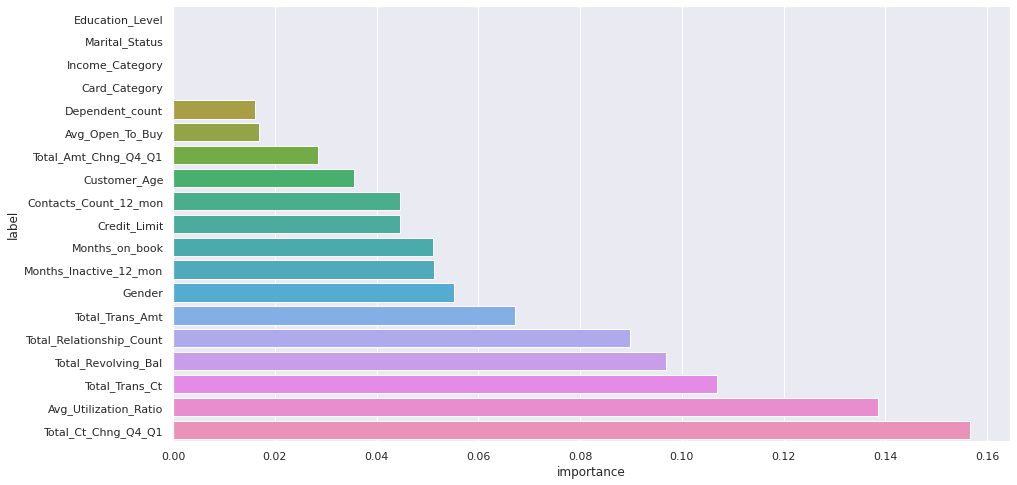

In [44]:
plt.figure(figsize=(15,8))
sns.barplot(y="label",x="importance",order=feature_df.sort_values("importance").label,data=feature_df)

#Other Classifiers

#Random Forest
 The input features here are:
1.   Encoded with integers and
2.   Imputed (null values are handled)

In [45]:
RF = RandomForestClassifier()
CV_mean_Kappa, CV_std_Kappa = cross_valid_fun(RF, x_train, y_train, 10, kappa_scorer)
CV_mean_F1, CV_std_F1 = cross_valid_fun(RF, x_train, y_train, 10, f1_scorer)

print("Kappa mean:{:.2f} std:{:.2f}".format(CV_mean_Kappa, CV_std_Kappa))
print("F1 mean:{:.2%} std:{:.2%}".format(CV_mean_F1, CV_std_F1))

Kappa mean:0.85 std:0.02
F1 mean:87.09% std:2.22%


Accuracy : 96.22%
F1 : 86.95%
Jaccard : 0.77
Kappa : 0.85
log_loss : 0.12 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2573
           1       0.92      0.82      0.87       466

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039



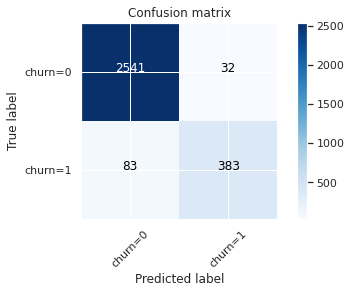

In [46]:
RF = RandomForestClassifier()
RF.fit(x_train,y_train)
y_hat = RF.predict(x_test)
y_prob = RF.predict_proba(x_test)

metrics(y_test, y_hat, y_prob)

#NB
 The input features here are:
1.   Encoded with integers and
2.   Imputed (null values are handled)

In [47]:
NB = GaussianNB()
CV_mean_Kappa, CV_std_Kappa = cross_valid_fun(NB, x_train, y_train, 10, kappa_scorer)
CV_mean_F1, CV_std_F1 = cross_valid_fun(NB, x_train, y_train, 10, f1_scorer)

print("Kappa mean:{:.2f} std:{:.2f}".format(CV_mean_Kappa, CV_std_Kappa))
print("F1 mean:{:.2%} std:{:.2%}".format(CV_mean_F1, CV_std_F1))

Kappa mean:0.59 std:0.04
F1 mean:65.64% std:3.49%


Accuracy : 89.87%
F1 : 66.00%
Jaccard : 0.49
Kappa : 0.60
log_loss : 0.29 

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2573
           1       0.68      0.64      0.66       466

    accuracy                           0.90      3039
   macro avg       0.81      0.79      0.80      3039
weighted avg       0.90      0.90      0.90      3039



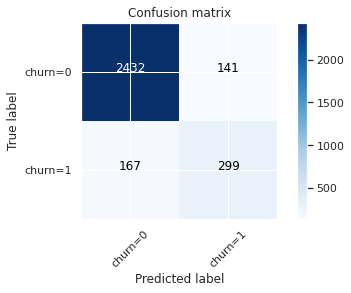

In [48]:
#Create a Gaussian Classifier
NB = GaussianNB()
# Train the model using the training sets
NB.fit(x_train, y_train)
y_hat = NB.predict(x_test)
y_prob = NB.predict_proba(x_test)

metrics(y_test, y_hat, y_prob)

#Logistic Regression
 The input features here are


1.   Encoded with integers;
2.   Imputed (null values are handled)
3. One-hot encoded
4. Standardised


In [49]:
# Using CV-10
clf = LogisticRegression(solver='sag')
CV_mean_Kappa, CV_std_Kappa = cross_valid_fun(clf, x_train_Stand, y_train, 10, kappa_scorer)
CV_mean_F1, CV_std_F1 = cross_valid_fun(clf, x_train_Stand, y_train, 10, f1_scorer)

print("Kappa mean:{:.2f} std:{:.2f}".format(CV_mean_Kappa, CV_std_Kappa))
print("F1 mean:{:.2%} std:{:.2%}".format(CV_mean_F1, CV_std_F1))

Kappa mean:0.61 std:0.05
F1 mean:66.47% std:4.08%


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy : 90.95%
F1 : 67.61%
Jaccard : 0.51
Kappa : 0.62
log_loss : 0.23 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2573
           1       0.75      0.62      0.68       466

    accuracy                           0.91      3039
   macro avg       0.84      0.79      0.81      3039
weighted avg       0.90      0.91      0.91      3039



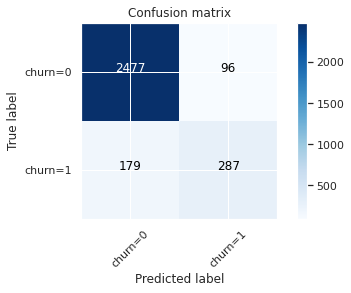

In [50]:
# Using Train-test split
clf = LogisticRegression(solver='sag')
# train the model
clf.fit(x_train_Stand, y_train)
y_hat = clf.predict(x_test_Stand)
# predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X):
y_prob = clf.predict_proba(x_test_Stand)

metrics(y_test_Stand, y_hat, y_prob)


#SVM

 The input features here are


1.   Encoded with integers;
2.   Imputed (null values are handled)
3. One-hot encoded
4. Standardised

In [51]:
svm = SVC()
CV_mean_Kappa, CV_std_Kappa = cross_valid_fun(svm, x_train_Stand, y_train, 10, kappa_scorer)
CV_mean_F1, CV_std_F1 = cross_valid_fun(svm, x_train_Stand, y_train, 10, f1_scorer)

print("Kappa mean:{:.2f} std:{:.2f}".format(CV_mean_Kappa, CV_std_Kappa))
print("F1 mean:{:.2%} std:{:.2%}".format(CV_mean_F1, CV_std_F1))

Kappa mean:0.72 std:0.04
F1 mean:76.12% std:3.21%


Accuracy : 93.88%
F1 : 78.27%
Jaccard : 0.64
Kappa : 0.75
log_loss : 0.16 

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2573
           1       0.86      0.72      0.78       466

    accuracy                           0.94      3039
   macro avg       0.90      0.85      0.87      3039
weighted avg       0.94      0.94      0.94      3039



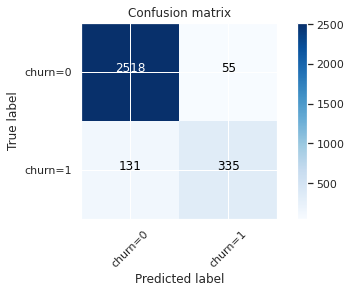

In [52]:
svm = SVC(probability=True)
svm.fit(x_train_Stand, y_train_Stand)
y_hat = svm.predict(x_test_Stand)
y_prob = svm.predict_proba(x_test_Stand)

metrics(y_test_Stand, y_hat, y_prob)


#Results Discussion
XGB and Random Forest Classifiers have the best results comparing to other classifiers. Also, less effort for preprocessing the features (short pipeline). The other classifiers have obtained worse results and require more effort to prepare the features (longer and more computationally expensive pipeline).